In [31]:
import torch
import torchvision

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torchvision.transforms as transforms
import numpy
import matplotlib.pyplot as plt

In [32]:
from trainer import *

# Model Def

In [33]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

# Training

In [34]:
batch_size_train = 128
batch_size_test = 128

In [35]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

In [36]:
trainloader =  torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./files/', train=True, download=True,
        transform=torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(
                (0.1307,), (0.3081,))
        ])),
        batch_size=batch_size_train, shuffle=True)
        
testloader =  torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./files/', train=False, download=True,
        transform=torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(
                (0.1307,), (0.3081,))
        ])),
        batch_size=batch_size_test, shuffle=True)

## SVLR

In [37]:
network_s = Net().cuda()
optimizer = optim.Adagrad(network_s.parameters(), lr=0.017)
criterion = F.nll_loss

In [38]:
slr_op = train_slr(network_s, trainloader, testloader, criterion, optimizer)

Epoch: 0


/tmp/ipykernel_89697/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Accuracy of the network for this batch: 79.9217 %
Epoch: 1
Accuracy of the network for this batch: 89.5767 %
Epoch: 2
Accuracy of the network for this batch: 91.0217 %
Epoch: 3
Accuracy of the network for this batch: 91.9033 %
Epoch: 4
Accuracy of the network for this batch: 92.7883 %
Epoch: 5
Accuracy of the network for this batch: 92.9900 %
Epoch: 6
Accuracy of the network for this batch: 93.3500 %
Epoch: 7
Accuracy of the network for this batch: 93.5683 %
Epoch: 8
Accuracy of the network for this batch: 93.6800 %
Epoch: 9
Accuracy of the network for this batch: 93.9433 %


In [39]:
slr_op

{'time': 139.56522274017334,
 'train_acc': [79.92166666666667,
  89.57666666666667,
  91.02166666666666,
  91.90333333333334,
  92.78833333333333,
  92.99,
  93.35,
  93.56833333333333,
  93.68,
  93.94333333333333],
 'test_acc': [88.38,
  91.15,
  92.24,
  92.59,
  93.15,
  93.45,
  94.15,
  93.99,
  93.9,
  93.89]}

## DVLR

In [40]:
correct_learning_rate = 0.017
cor_lr_change = correct_learning_rate * 0.01
incorrect_learning_rate = 0.003
incor_lr_change = incorrect_learning_rate * 0.01

In [41]:
network_d = Net().cuda()
optimizer = optim.Adagrad(network_d.parameters(), lr=correct_learning_rate)
criterion = F.nll_loss

In [42]:
params = {'cor_lr': correct_learning_rate, 
          'cor_lr_change': cor_lr_change, 
          'incor_lr': incorrect_learning_rate, 
          'incor_lr_change': incor_lr_change,
          'cor_min': 19995,
          'cor_max': 20005,
          'incor_min': 1995,
          'incor_max': 2005}

In [43]:
dlr_op = train_dlr(network_d, trainloader, testloader, criterion, optimizer, batch_size_train, params)

Epoch: 0


/tmp/ipykernel_89697/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Accuracy of the network for this batch: 84.1433 %
Epoch: 1
Accuracy of the network for this batch: 92.8617 %
Epoch: 2
Accuracy of the network for this batch: 93.8800 %
Epoch: 3
Accuracy of the network for this batch: 94.4550 %
Epoch: 4
Accuracy of the network for this batch: 94.8050 %
Epoch: 5
Accuracy of the network for this batch: 95.0517 %
Epoch: 6
Accuracy of the network for this batch: 95.2000 %
Epoch: 7
Accuracy of the network for this batch: 95.3733 %
Epoch: 8
Accuracy of the network for this batch: 95.5833 %
Epoch: 9
Accuracy of the network for this batch: 95.7783 %


In [44]:
dlr_op

{'time': 139.61774516105652,
 'train_acc': [84.14333333333333,
  92.86166666666666,
  93.88,
  94.455,
  94.805,
  95.05166666666666,
  95.2,
  95.37333333333333,
  95.58333333333333,
  95.77833333333334],
 'test_acc': [92.14,
  93.99,
  94.56,
  94.82,
  95.35,
  95.42,
  95.24,
  95.73,
  95.71,
  95.68],
 'cor_lr': 0.013600000000000001,
 'incor_lr': 0.003420000000000001}

# Comparison

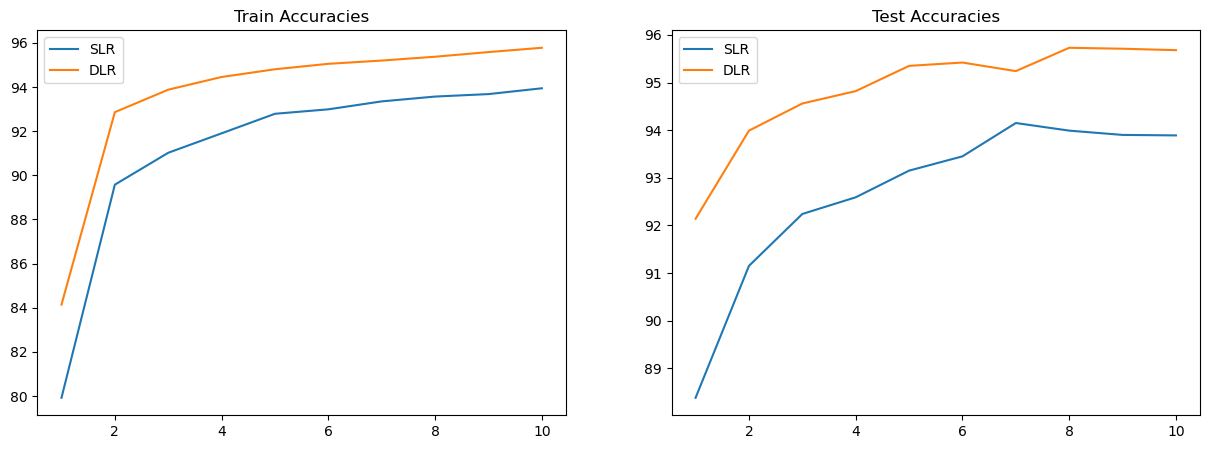

In [45]:
epoch_range = range(1, 11)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# plt.figure(211)
ax[0].plot(epoch_range, slr_op['train_acc'], label='SLR')
ax[0].plot(epoch_range, dlr_op['train_acc'], label='DLR')
ax[0].set_title("Train Accuracies")
ax[0].legend()
# ax[0].show()

# plt.figure(212)
ax[1].plot(epoch_range, slr_op['test_acc'], label='SLR')
ax[1].plot(epoch_range, dlr_op['test_acc'], label='DLR')
ax[1].set_title("Test Accuracies")
ax[1].legend()
# ax[1].show()